In [ ]:
import scipy
import torch
from diffusers import DDPMScheduler
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
import os
import glob
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from scipy import linalg
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np

In [22]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom UNet2DConditionModel with reduced parameters
class CustomUNet2DConditionModel(UNet2DConditionModel):
    def __init__(self, **kwargs):
        super().__init__(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,  # Reduced from default
            block_out_channels=(32, 64, 64, 32),  # Reduced from default
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
            ),
            cross_attention_dim=512,  # CLIP embedding dimension
            **kwargs
        )

# Load models
unet = CustomUNet2DConditionModel().to(device)


In [23]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE and text encoder
# vae.requires_grad_(False)
## set requires_grad_ to true so that the text_enocder aka CLIP model is also trained.
text_encoder.requires_grad_(False)
# tokenizer.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [24]:
tokenizer.model_max_length ## 77

77

In [25]:
TOKENIZER_MAX_LENGTH = 8
captions_sample = ['"A handwritten digit 1']
text_input = tokenizer(captions_sample, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape

## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 8, 512])

In [26]:
num_of_params = sum([p.numel() for p in unet.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 3,140,385


In [27]:
# Load checkpoint

# Find the latest checkpoint
checkpoint_dir = "./checkpoints"
if os.path.exists(checkpoint_dir):
    checkpoints = glob.glob(os.path.join(checkpoint_dir, "train1_unet_checkpoint_epoch_*.pt"))
    if checkpoints:
        # Sort by epoch number and get the lates    t
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))
        print(f"Loading checkpoint: {latest_checkpoint}")
        
        checkpoint = torch.load(latest_checkpoint, map_location=device)
        unet.load_state_dict(checkpoint["unet_state_dict"])
        print(f"Loaded model from epoch {checkpoint['epoch']}")
    else:
        print("No checkpoints found in ./checkpoints/")
        exit(1)
else:
    print("Checkpoint directory does not exist. Please train the model first or specify the correct path.")
    exit(1)

Loading checkpoint: ./checkpoints/train1_unet_checkpoint_epoch_20.pt
Loaded model from epoch 20


/tmp/ipykernel_118140/3580609743.py:18: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:01<00:00, 41.87it/s]


torch.Size([1, 1, 28, 28])


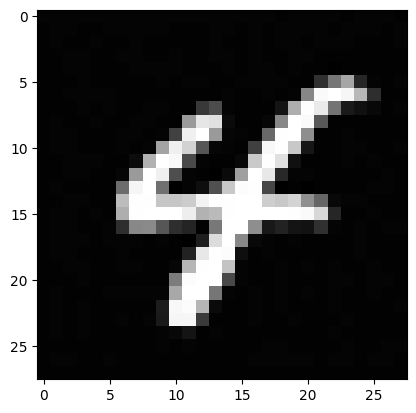

In [ ]:
# Set models to evaluation mode
# vae.eval()
text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
# guidance_scale = 100

@torch.no_grad()
def generate_image(prompt):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Initialize latents / create noisy image.
    # IMPORTANT: do NOT reset the RNG seed inside this function.
    latents = torch.randn((1, unet.config.in_channels, 28, 28), device=device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        # Prepare latent model input
        latent_model_input = scheduler.scale_model_input(latents, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image = latents
    print(image.shape)
    # Post-process image ## i.e reverse the normalization
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

# Generate an image
prompt = "A handwritten digit 4"
generated_image = generate_image(prompt)

# Display or save the image
image = generated_image[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
image = (image * 255).round().astype("uint8")
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()

In [29]:
## save unet and text_encoder
# Save the trained model
# torch.save(unet.state_dict(), "./unet.pth")


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 41.50it/s]


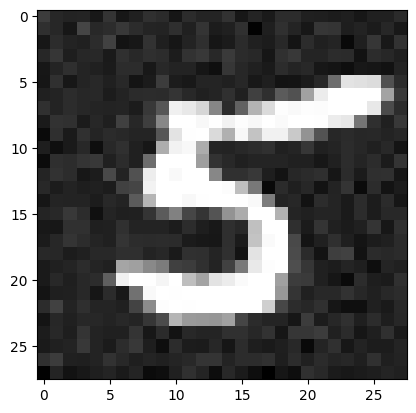

In [42]:
# Set models to evaluation mode
# vae.eval()
# text_encoder.eval()  # already set earlier
unet.eval()

# Inference parameters
num_inference_steps = 50

@torch.no_grad()
def generate_image(prompt, guidance_scale, num_images=1):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents.
    # IMPORTANT: do NOT reset the RNG seed inside this function.
    latents = torch.randn((num_images, unet.config.in_channels, 28, 28), device=device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image (pixel-space, no VAE)
    image = (latents / 2 + 0.5).clamp(0, 1)
    return image

# Quick demo
prompt = "A handwritten digit 5"
# For reproducible demos, set the seed ONCE here (not inside generate_image)
torch.manual_seed(422)
generated_images = generate_image(prompt, guidance_scale=8)

# Display or save the image
image = generated_images[0].squeeze(0).detach().cpu().numpy()
image = (image * 255).round().astype("uint8")
plt.imshow(image, cmap='gray')
plt.show()

/tmp/ipykernel_118140/2564779507.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:01<00:00, 42.17it/s]


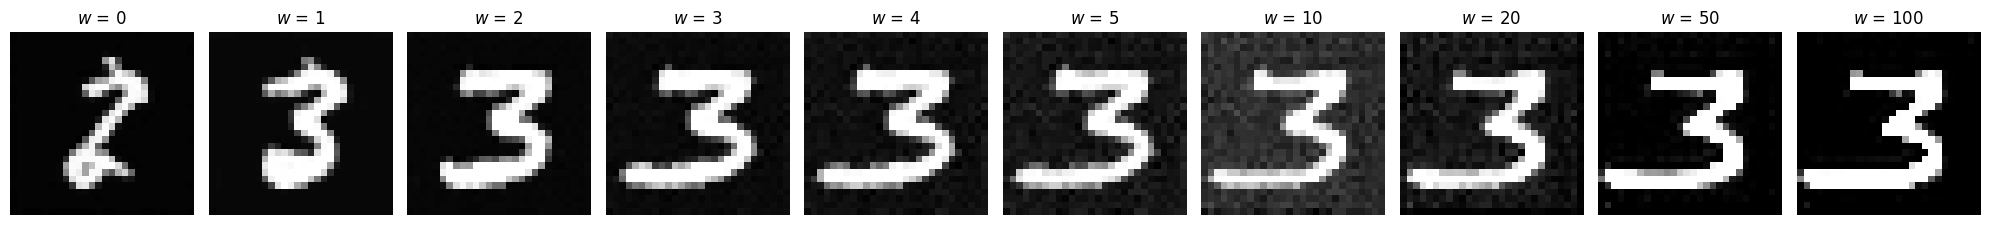

In [31]:
# Define the guidance scale values
guidance_scales = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100]

# Initialize a figure with a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(guidance_scales), figsize=(20, 4))

# Generate an image for each guidance scale value
for i, guidance_scale in enumerate(guidance_scales):
    # Generate an image
    prompt = "A handwritten digit 3"
    generated_image = generate_image(prompt, guidance_scale=guidance_scale)

    # Display or save the image
    image = generated_image[0]  # Remove the extra dimension
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()  # Remove batch dimension
    image = (image * 255).round().astype("uint8")

    # Display the image in the current subplot
    axs[i].imshow(image, cmap='gray')  # Display as grayscale image
    axs[i].set_title(f'$w$ = {guidance_scale}')
    axs[i].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()

/tmp/ipykernel_118140/2564779507.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:01<00:00, 42.37it/s]


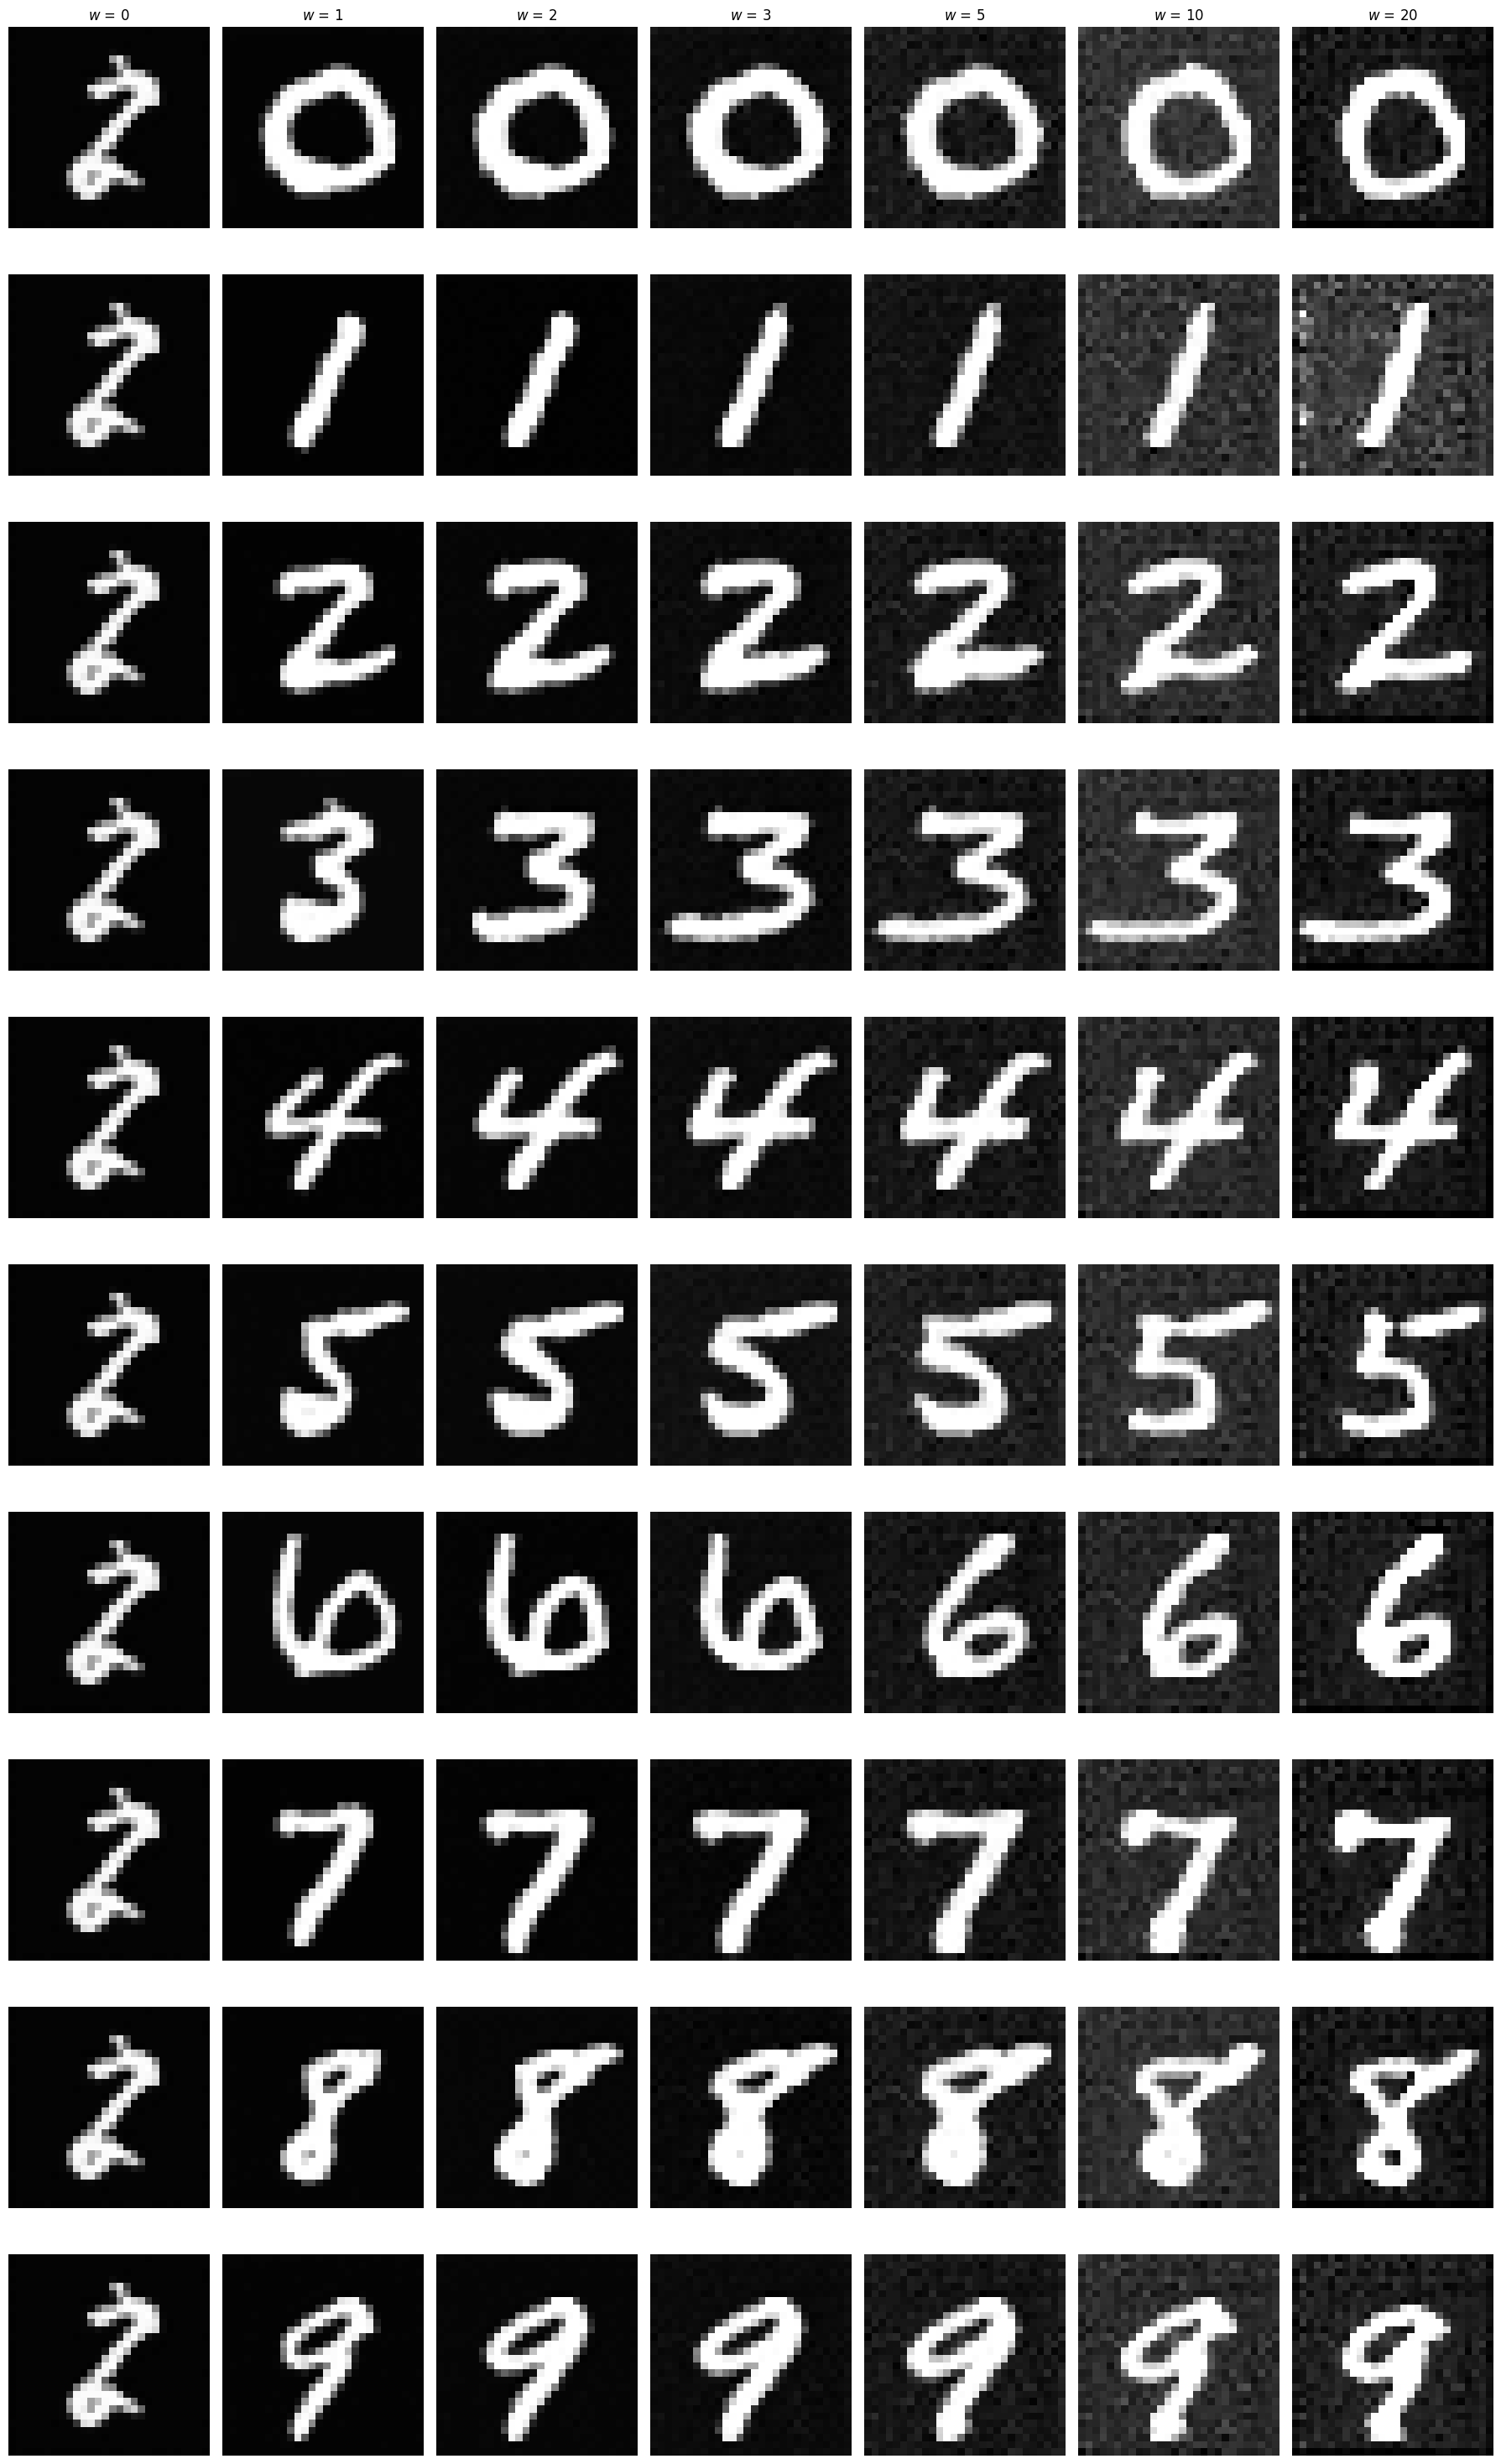

In [32]:
# Generate images for all digits (0-9) across different guidance scales
digits = list(range(10))  # 0 through 9
guidance_scales = [0, 1, 2, 3, 5, 10, 20]

# Initialize a figure with a grid: 10 rows (one per digit) x 6 columns (one per guidance scale)
fig, axs = plt.subplots(nrows=len(digits), ncols=len(guidance_scales), figsize=(18, 30))

# Generate images for each digit and guidance scale
for row_idx, digit in enumerate(digits):
    for col_idx, guidance_scale in enumerate(guidance_scales):
        # Generate an image
        prompt = f"A handwritten digit {digit}"
        generated_image = generate_image(prompt, guidance_scale=guidance_scale)
        
        # Display or save the image
        image = generated_image[0]  # Remove the extra dimension
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()  # Remove batch dimension
        image = (image * 255).round().astype("uint8")
        
        # Display the image in the current subplot
        axs[row_idx, col_idx].imshow(image, cmap='gray')
        
        # Add title only to first row (guidance scale labels)
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(f'$w$ = {guidance_scale}')
        
        # Add ylabel only to first column (digit labels)
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel(f'Digit {digit}', fontsize=12, rotation=0, labelpad=30)
        
        axs[row_idx, col_idx].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()

Real-vs-Real baseline FID (N=200): 26.56


gen(w=0.0): 100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


w=  0: FID (N=200) = 230.51


gen(w=1.0): 100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


w=  1: FID (N=200) = 250.75


gen(w=2.0): 100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


w=  2: FID (N=200) = 255.61


gen(w=5.0): 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


w=  5: FID (N=200) = 269.53


gen(w=8.0): 100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


w=  8: FID (N=200) = 287.03


gen(w=10.0): 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


w= 10: FID (N=200) = 285.10


gen(w=20.0): 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


w= 20: FID (N=200) = 262.66


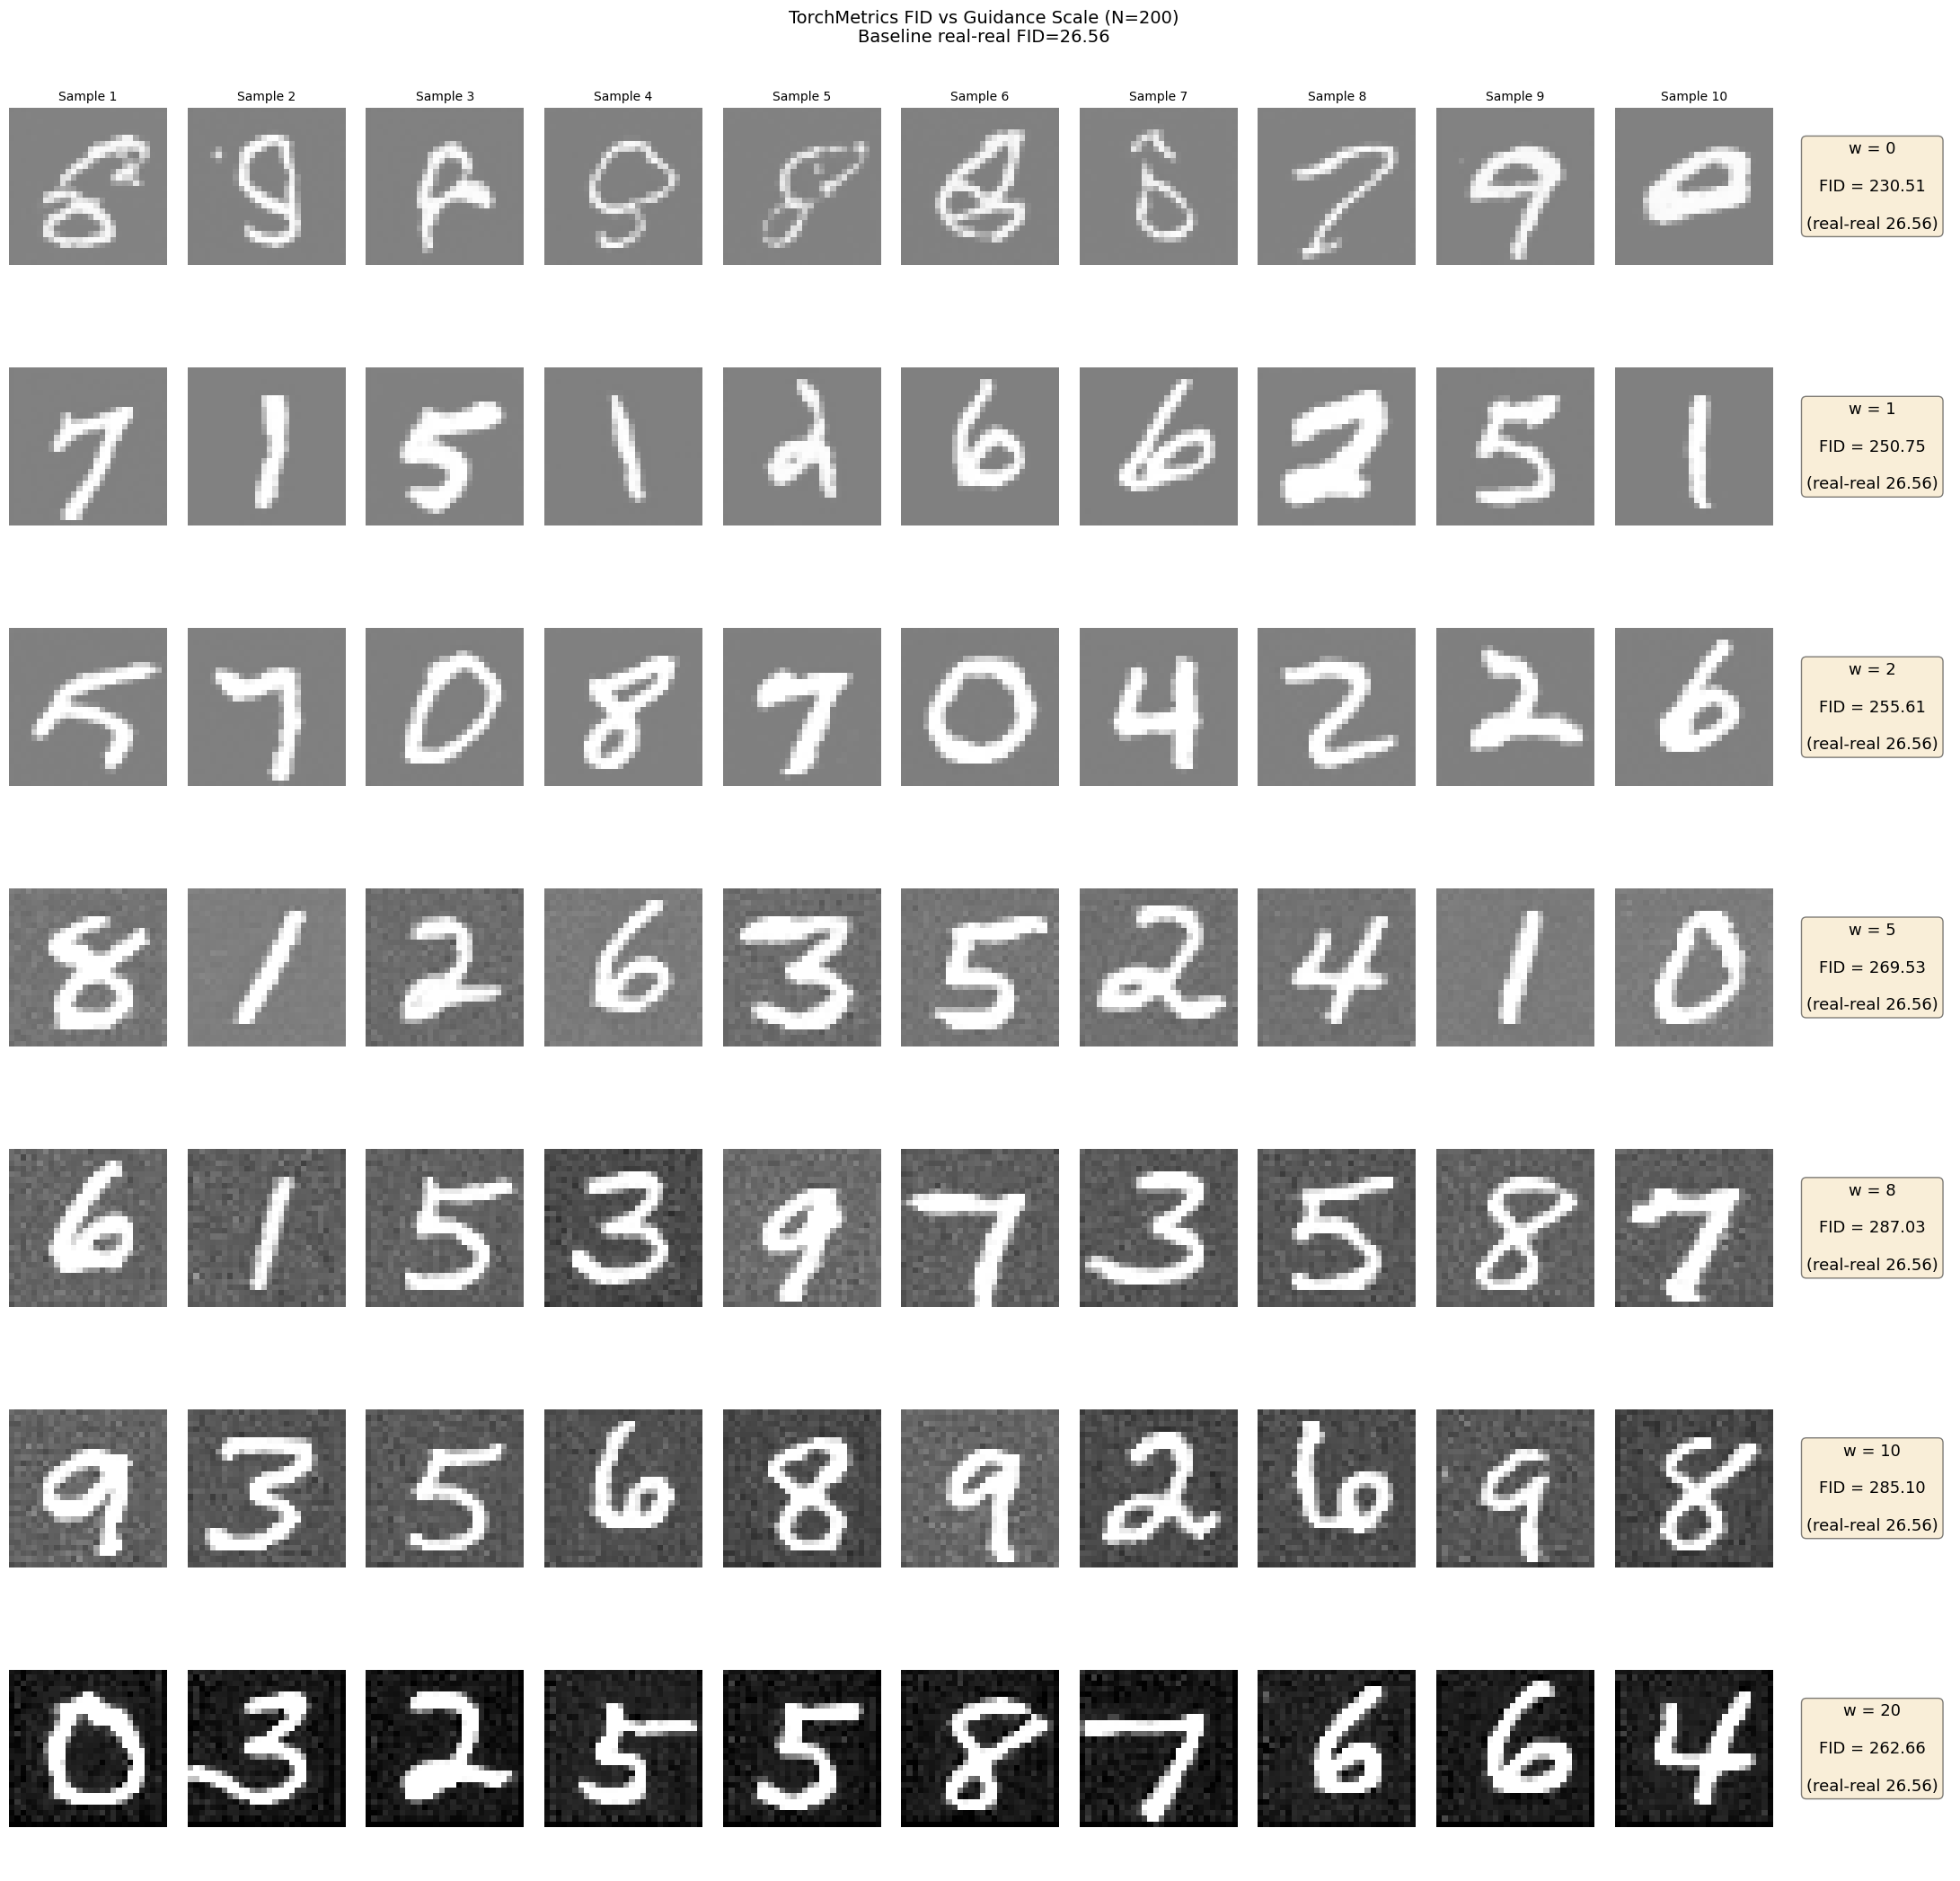

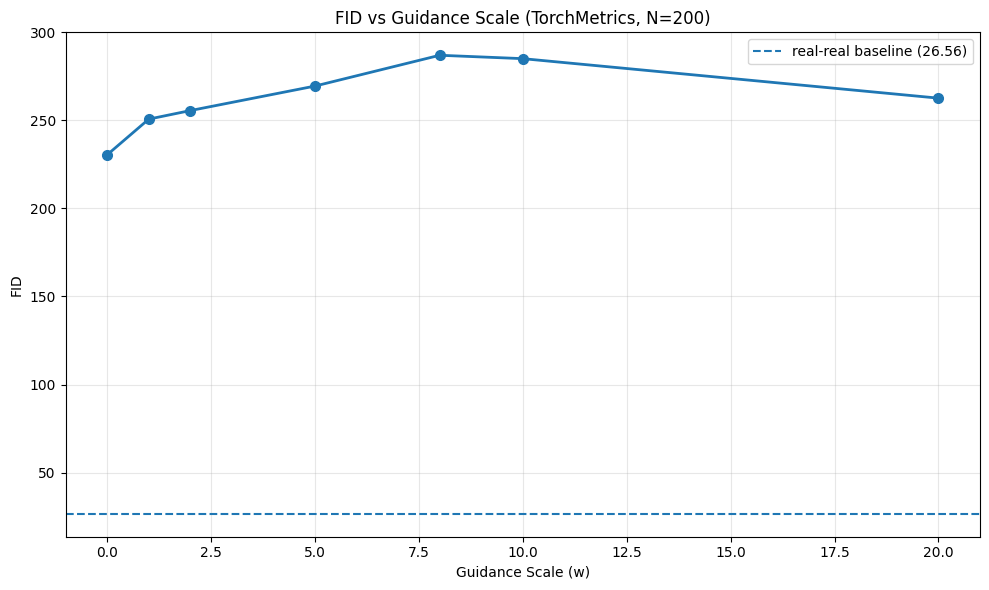


=== Summary ===
Real-vs-Real baseline (N=200): 26.56
w=  0: FID =  230.51
w=  1: FID =  250.75
w=  2: FID =  255.61
w=  5: FID =  269.53
w=  8: FID =  287.03
w= 10: FID =  285.10
w= 20: FID =  262.66


In [43]:
# FID (Option B): TorchMetrics implementation (more reliable than manual Inception + sqrtm)

# NOTE:
# - FID is only stable with large sample sizes (>= 1k recommended). This generator is slow,
#   so start with 100-300 for debugging, then scale up if you have time.
# - If you get "ModuleNotFoundError: torchmetrics", install it in this kernel:
#   !pip install torchmetrics

try:
    from torchmetrics.image.fid import FrechetInceptionDistance
except Exception as e:
    raise ImportError(
        "torchmetrics is required for Option B FID. Install with: !pip install torchmetrics\n"
        f"Original error: {e}"
    )


def _to_uint8_rgb01(x01: torch.Tensor) -> torch.Tensor:
    """Convert (N,1,H,W) or (N,3,H,W) float in [0,1] -> uint8 RGB (N,3,H,W) in [0,255]."""
    if x01.dim() != 4:
        raise ValueError(f"Expected 4D tensor (N,C,H,W), got shape {tuple(x01.shape)}")
    if x01.size(1) == 1:
        x01 = x01.repeat(1, 3, 1, 1)
    elif x01.size(1) != 3:
        raise ValueError(f"Expected C=1 or C=3, got C={x01.size(1)}")

    x01 = x01.clamp(0, 1)
    x255 = (x01 * 255.0).round().to(torch.uint8)
    return x255


def sample_real_mnist_uint8(n: int, dataset: MNIST) -> torch.Tensor:
    """Sample n real MNIST images and return uint8 RGB tensor (N,3,28,28)."""
    idx = np.random.choice(len(dataset), n, replace=False)
    imgs = []
    for i in idx:
        img, _ = dataset[i]  # img is (1,28,28) normalized to ~[-1,1]
        img01 = (img * 0.5 + 0.5).clamp(0, 1)
        imgs.append(img01)
    imgs = torch.stack(imgs, dim=0)
    return _to_uint8_rgb01(imgs)


def sample_generated_uint8(n: int, guidance_scale: float) -> torch.Tensor:
    """Generate n images and return uint8 RGB tensor (N,3,28,28)."""
    prompts = [f"A handwritten digit {i}" for i in range(10)]
    imgs = []
    for _ in tqdm(range(n), desc=f"gen(w={guidance_scale})"):
        prompt = np.random.choice(prompts)
        out = generate_image(prompt, guidance_scale=guidance_scale, num_images=1)  # (1,1,28,28) in [0,1]
        img01 = out[0].detach().cpu()
        imgs.append(img01)
    imgs = torch.stack(imgs, dim=0)
    return _to_uint8_rgb01(imgs)


def compute_fid_torchmetrics(real_uint8: torch.Tensor, fake_uint8: torch.Tensor, device: torch.device) -> float:
    """Compute FID using TorchMetrics. Inputs must be uint8 RGB tensors (N,3,H,W)."""
    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    fid.update(real_uint8.to(device), real=True)
    fid.update(fake_uint8.to(device), real=False)
    return float(fid.compute().detach().cpu())


# ----------------------------
# Configuration
# ----------------------------

guidance_scales_to_test = [0, 1, 2, 5, 8, 10, 20]

FID_NUM_SAMPLES = 200  # Increase toward 1000+ for a publishable number
NUM_IMAGES_TO_DISPLAY = 10

# Fix RNG so comparisons are consistent across runs
np.random.seed(123)
torch.manual_seed(123)

# ----------------------------
# Baseline (real vs real)
# ----------------------------

real_A = sample_real_mnist_uint8(FID_NUM_SAMPLES, test_dataset)
real_B = sample_real_mnist_uint8(FID_NUM_SAMPLES, test_dataset)

fid_real_vs_real = compute_fid_torchmetrics(real_A, real_B, device)
print(f"Real-vs-Real baseline FID (N={FID_NUM_SAMPLES}): {fid_real_vs_real:.2f}")

# ----------------------------
# Model FID across guidance scales
# ----------------------------

fid_results = {}

fig, axs = plt.subplots(
    nrows=len(guidance_scales_to_test),
    ncols=NUM_IMAGES_TO_DISPLAY + 1,
    figsize=(22, 3 * len(guidance_scales_to_test)),
)

for row_idx, w in enumerate(guidance_scales_to_test):
    fake_uint8 = sample_generated_uint8(FID_NUM_SAMPLES, guidance_scale=float(w))

    fid_val = compute_fid_torchmetrics(real_A, fake_uint8, device)
    fid_results[w] = fid_val
    print(f"w={w:>3}: FID (N={FID_NUM_SAMPLES}) = {fid_val:.2f}")

    # Show a few samples (convert back to grayscale for display)
    num_to_show = min(NUM_IMAGES_TO_DISPLAY, fake_uint8.size(0))
    for col_idx in range(num_to_show):
        img = fake_uint8[col_idx]  # (3,28,28) uint8
        img_gray = img[0].numpy()
        axs[row_idx, col_idx].imshow(img_gray, cmap="gray", vmin=0, vmax=255)
        axs[row_idx, col_idx].axis("off")
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(f"Sample {col_idx+1}", fontsize=10)

    for col_idx in range(num_to_show, NUM_IMAGES_TO_DISPLAY):
        axs[row_idx, col_idx].axis("off")

    axs[row_idx, NUM_IMAGES_TO_DISPLAY].text(
        0.5,
        0.5,
        f"w = {w}\n\nFID = {fid_val:.2f}\n\n(real-real {fid_real_vs_real:.2f})",
        ha="center",
        va="center",
        fontsize=13,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )
    axs[row_idx, NUM_IMAGES_TO_DISPLAY].axis("off")

fig.suptitle(
    f"TorchMetrics FID vs Guidance Scale (N={FID_NUM_SAMPLES})\nBaseline real-real FID={fid_real_vs_real:.2f}",
    fontsize=14,
    y=0.995,
)
plt.tight_layout()
plt.show()

# FID curve
fig2, ax = plt.subplots(figsize=(10, 6))
scales = list(fid_results.keys())
vals = list(fid_results.values())
ax.plot(scales, vals, marker="o", linewidth=2, markersize=7)
ax.axhline(fid_real_vs_real, linestyle="--", linewidth=1.5, label=f"real-real baseline ({fid_real_vs_real:.2f})")
ax.set_xlabel("Guidance Scale (w)")
ax.set_ylabel("FID")
ax.set_title(f"FID vs Guidance Scale (TorchMetrics, N={FID_NUM_SAMPLES})")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"Real-vs-Real baseline (N={FID_NUM_SAMPLES}): {fid_real_vs_real:.2f}")
for w, fid_val in fid_results.items():
    print(f"w={w:>3}: FID = {fid_val:7.2f}")